In [43]:
using Plots, Colors, DataFrames, CSV, GLM

cd("/Users/junwong/Dropbox/Second Year/Dingel - Trade/Assignments")

# Quantitative Model

## Calibrating $X_{ni}$

In [44]:
df = DataFrame(CSV.File("data/bilateral_trade_country/bilateral_trade_country.csv"))

Xₙᵢ⁰ = unstack(df, :country_dest, :country_org, :trade_flow2014)
Xₙᵢ⁰ = Array(Xₙᵢ⁰[!,2:43])

exp⁰ = combine(groupby(df, :country_org), :trade_flow2014 => sum, renamecols=false);
imp⁰ = combine(groupby(df, :country_dest), :trade_flow2014 => sum, renamecols=false);
rename!(imp⁰, :trade_flow2014 => :imports)
yₙ = exp⁰[!,2] ./ imp⁰[!,2];

df = leftjoin(df, imp⁰, on=:country_dest);
transform!(df, [:trade_flow2014, :imports] => (./) => :pi_ni);
πₙᵢ = unstack(df, :country_dest, :country_org, :pi_ni);
πₙᵢ = Array(πₙᵢ[!, 2:43]);

## Impact of a 10% increase in Chinese productivity

In [45]:
# Setting T̂ₙᵢ
T̂ₙᵢ = ones(42,1);
T̂ₙᵢ[8] = 1.1;
θ = 4;

# Initialize vectors
ŵ = ones(42, 1);

# Transfer numeraire
h(w) = w[end]

# Parameters
tol = 1e-10
κ=0.01

0.01

In [46]:
# Excess demand function 
excess_demand = function(ŵ, Xₙᵢ⁰, T̂, πₙᵢ, yₙ, θ, w0)
    # get the denominator that is by n
    dni = zeros(length(T̂), length(T̂))  
    for i = 1:size(Xₙᵢ⁰, 2)
        for n = 1:size(Xₙᵢ⁰, 1)
            dni[n, i] = πₙᵢ[n, i] .* T̂[i] .* (ŵ[i] .^ (-θ))
        end
    end 
    
    # get the rest of the calculations
    res_i = zeros(length(T̂), 1)
    for i = 1:size(Xₙᵢ⁰, 2)
        res_by_n = zeros(length(T̂), 1)
        denom_i = sum(Xₙᵢ⁰[:,i])
        for n = 1:size(Xₙᵢ⁰, 1)
            num_ni = Xₙᵢ⁰[n, i] * T̂[i] * ((ŵ[i]) ^ (-θ))
            num_n = yₙ[n] .* ŵ[n] .+ (1 .- yₙ[n]) .* h(w0 .* ŵ) ./ h(w0)
            denom_n = sum(dni[n, :])
            res_by_n[n] = num_n * num_ni / denom_i / denom_n
        end
        res_i[i] = sum(res_by_n) - ŵ[i]
    end
    
    return res_i
end 

#25 (generic function with 1 method)

In [47]:
# Iterating wrapper
iterating_fn = function(ŵ, Xₙᵢ⁰, T̂, πₙᵢ, yₙ, θ, w0, tol, κ) 
    zᵢ = ones(length(T̂))
    
    while maximum(abs.(zᵢ)) > tol
        iter +=1
        zᵢ = excess_demand(ŵ, Xₙᵢ⁰, T̂, πₙᵢ, yₙ, θ, w0) 
        ŵ = ŵ .+ κ .* zᵢ
        ŵ[end] = 1
    end 
    
    return [ŵ, zᵢ, iter]
end     

#27 (generic function with 1 method)

In [48]:
# Run function
x = iterating_fn(ones(42, 1), Xₙᵢ⁰, T̂ₙᵢ, πₙᵢ, yₙ, θ, ones(42,1), tol, κ)

-0.0042254001559204335-0.0015119267799735825-0.002018234018251519-0.001677863566966642-0.0018846207780900404
-0.004193258934968802-0.0015267574532096262-0.0020227695971866133-0.0016930638454645264-0.001882322870565778
-0.004161191664822095-0.0015409559937860084-0.0020267584542281725-0.001707544465341826-0.001879861209081568
-0.004129201368371915-0.001554537052483318-0.002030216829291387-0.001721323019064358-0.001877239502255601
-0.004097290982414847-0.001567514976260287-0.0020331605598602476-0.001734416721110854-0.0018744613950235633
-0.004065463359336108-0.0015799038143492483-0.0020356050900363076-0.0017468424157557338-0.0018715304696413915


3-element Vector{Any}:
  [0.9997512819353416; 0.9999071840392993; … ; 0.999339151257065; 1.0]
  [-0.004065463359336108; -0.0015799038143492483; … ; -0.010411379406528587; -0.0015346030449434611]
 6

## Changes in Real Wage and Expenditures

Construct terms

In [57]:
Φ̂ₙ = zeros(42)
ni = zeros(42, 42)
for n=1:42
    for i=1:42
        ni[n, i] = T̂ₙᵢ[n] * πₙᵢ[n,i] * (x[1][i]^(-θ)) # add T in here 
    end
    Φ̂ₙ[n] = sum(ni[n, :])
end

# New CES price index
P̂ₙ = (Φ̂ₙ).^(-1/θ);

# Real wage
ω̂ = x[1] ./ P̂ₙ

# Share of spending of n on i 
π̂ₙᵢ = zeros(42, 42)
dₙᵢ = ones(42, 42)
for n = 1:size(dₙᵢ, 1)
    for i = 1:size(dₙᵢ, 2) 
        π̂ₙᵢ[n, i] = T̂ₙᵢ[i] * (dₙᵢ[n, i] * x[1][i])^(-θ) / Φ̂ₙ[n]
    end
end

# Change in domestic trade share 
π̂ₙₙ = T̂ₙᵢ .* (x[1] ./ P̂ₙ).^(-θ)

# New expenditures
X̂ₙ = x[1] .+ h(x[1])
Χ̂ₙ = X̂ₙ ./ P̂ₙ;

Regressions

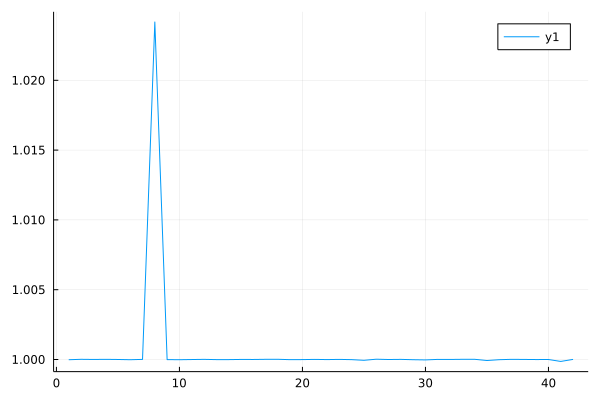

In [58]:
plot(ω̂)

In [61]:
reg_data = hcat(ω̂,  Χ̂ₙ, Φ̂ₙ,  π̂ₙₙ, πₙᵢ[:,8])
reg_data = DataFrame(reg_data, :auto)
rename!(reg_data, [:real_wage, :real_exp, :market_acc, :domestic_share, :initial_chn]);

In [64]:
lm(@formula(real_wage ~ market_acc + domestic_share + initial_chn), reg_data)
lm(@formula(real_exp ~ market_acc + domestic_share + initial_chn), reg_data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

real_wage ~ 1 + market_acc + domestic_share + initial_chn

Coefficients:
────────────────────────────────────────────────────────────────────────────────
                     Coef.  Std. Error      t  Pr(>|t|)   Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────
(Intercept)      0.743357    0.117031    6.35    <1e-06   0.506439    0.980275
market_acc      -0.0466133   0.0284001  -1.64    0.1090  -0.104106    0.0108797
domestic_share   0.303094    0.135206    2.24    0.0309   0.0293829   0.576804
initial_chn     -0.032602    0.0152937  -2.13    0.0396  -0.0635625  -0.00164147
────────────────────────────────────────────────────────────────────────────────

## Changing numeraire

In [59]:
# Transfer numeraire
h(w) = w[8] # china is now transfer numeraire 
x = iterating_fn(ones(42, 1), Xₙᵢ⁰, T̂ₙᵢ, πₙᵢ, yₙ, θ, ones(42,1), tol, κ)

-0.0042254001559204335-0.0015119267799735825-0.002018234018251519-0.001677863566966642-0.0018846207780900404
-0.004193108976557114-0.001529325748900745-0.0020254926506377835-0.001690938930129282-0.001880917178967878
-0.0041608896648086535-0.0015460702706919793-0.002032152035858714-0.0017033646642435896-0.0018770659963354142
-0.004128745405960643-0.0015621746743827991-0.0020382291644368555-0.0017151567362284625-0.0018730708633213355
-0.004096679294886996-0.0015776530059850025-0.0020437406201674335-0.0017263307694155294-0.0018689353483046789
-0.0040646943378225275-0.0015925190339086681-0.0020487025888902277-0.0017369020506111665-0.0018646629559504468


3-element Vector{Any}:
  [0.9997513048216404; 0.9999068033048615; … ; 0.9993383592978293; 1.0]
  [-0.0040646943378225275; -0.0015925190339086681; … ; -0.010437223107861548; -0.0015257894702489505]
 6

In [62]:
Φ̂ₙ = zeros(42)
ni = zeros(42, 42)
for n=1:42
    for i=1:42
        ni[n, i] = T̂ₙᵢ[n] * πₙᵢ[n,i] * (x[1][i]^(-θ))
    end
    Φ̂ₙ[n] = sum(ni[n, :])
end

# New CES price index
P̂ₙ = (Φ̂ₙ).^(-1/θ);

# Share of spending of n on i 
π̂ₙᵢ = zeros(42, 42)
dₙᵢ = ones(42, 42)
for n = 1:size(dₙᵢ, 1)
    for i = 1:size(dₙᵢ, 2) 
        π̂ₙᵢ[n, i] = T̂ₙᵢ[i] * (dₙᵢ[n, i] * x[1][i])^(-θ) / Φ̂ₙ[n]
    end
end

# New expenditures
X̂ₙ = x[1] .+ h(x[1]);

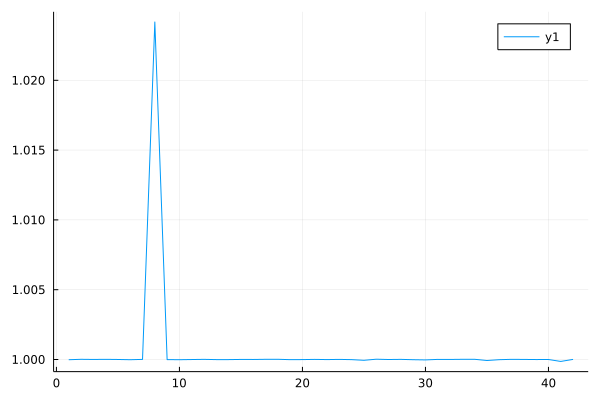

In [63]:
plot(x[1]./P̂ₙ)